Ce factori determinau preţul unui PC în vremea apariţiei acestora? Fişierul Prices.csv descrie un eşantion de 500 de vânzări de PC, colectat din 1993 până în 1995 în Statele Unite. Pe lângă preţul de vânzare, au fost colectate informaţii despre frecvenţa procesorului în MHz, dimensiunea hard diskului în MB, dimensiunea Ram în MB şi dacă producătorul este premium (de exemplu, IBM, COMPAQ). Să presupunem că se ia în considerare modelul de regresie y ∼ N (μ, σ), unde μ = α + β1x1 + β2x2, y este preţul de vânzare, x1 este frecvenţa procesorului şi x2 este logaritmul (natural) al mărimii hard diskului.
1. Folosind distribuţii a priori slab informative asupra parametrilor α, β1, β2 şi σ, folosiţi PyMC pentru a simula un eşantion suficient de mare din distribuţia a posteriori.

In [3]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

file_path = '/content/sample_data/Prices.csv'
data = pd.read_csv(file_path)

data['log_HardDrive'] = np.log(data['HardDrive'])

y = data['Price']
x1 = data['Speed']
x2 = data['log_HardDrive']

with pm.Model() as model:
    # distrb a priori slab informative
    alpha = pm.Normal('alpha', mu=0, sigma=10) # distrb normala gaussiana
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10) # distrb normala pozitiva

    # relatia de regresie liniara -> media modelului
    mu = alpha + beta1 * x1 + beta2 * x2

    # distrb observatiilor cu media [mu] si deviatia standard [sigma]
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Sampling din distrb a posteriori (2000 de esantioane din care 1000 pentru tuning)
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

print(az.summary(trace))

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━  64% 0:00:04 / 0:00:10

          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha   38.990  9.756   19.833   56.510      0.195    0.140    2514.0   
beta1   15.563  0.659   14.264   16.757      0.015    0.011    1869.0   
beta2  224.819  6.211  213.466  236.801      0.143    0.101    1874.0   
sigma  316.911  4.866  307.690  325.839      0.097    0.069    2487.0   

       ess_tail  r_hat  
alpha    2026.0    1.0  
beta1    2357.0    1.0  
beta2    2225.0    1.0  
sigma    2449.0    1.0  


2. Obţineţi estimări de 95% HDI ale parametrilor β1 şi β2.

In [4]:
# Calcularea HDI pentru beta1 si beta2
beta1_hdi = az.hdi(trace.posterior['beta1'], hdi_prob=0.95)
beta2_hdi = az.hdi(trace.posterior['beta2'], hdi_prob=0.95)

#intervale HDI
print(f"95% HDI pentru beta1 (frecventa procesorului): {beta1_hdi}")
print(f"95% HDI pentru beta2 (log dimensiunea hard disk-ului): {beta2_hdi}")

95% HDI pentru beta1 (frecvența procesorului): <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta1    (hdi) float64 16B 14.2 16.8
95% HDI pentru beta2 (log dimensiunea hard disk-ului): <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta2    (hdi) float64 16B 212.7 237.1


3. Pe baza rezultatelor obţinute, sunt frecvenţa procesorului şi mărimea hard diskului predictori utili ai preţului de vânzare?

In [5]:
if 0 not in beta1_hdi:
    print("Frecvența procesorului este un predictor semnificativ.")
else:
    print("Frecvența procesorului NU este un predictor semnificativ.")

if 0 not in beta2_hdi:
    print("Dimensiunea hard disk-ului este un predictor semnificativ.")
else:
    print("Dimensiunea hard disk-ului NU este un predictor semnificativ.")

Frecvența procesorului este un predictor semnificativ.
Dimensiunea hard disk-ului este un predictor semnificativ.


4. Să presupunem acum că un consumator este interesat de un computer cu o frecvenţă de 33 MHz şi un hard disk de 540 MB. Simulaţi 5000 de extrageri din preţul de vânzare aşteptat (μ) şi construiţi un interval de 90% HDI pentru acest preţ.

90% HDI pentru prețul așteptat: [1934.78258248 2001.43193488]


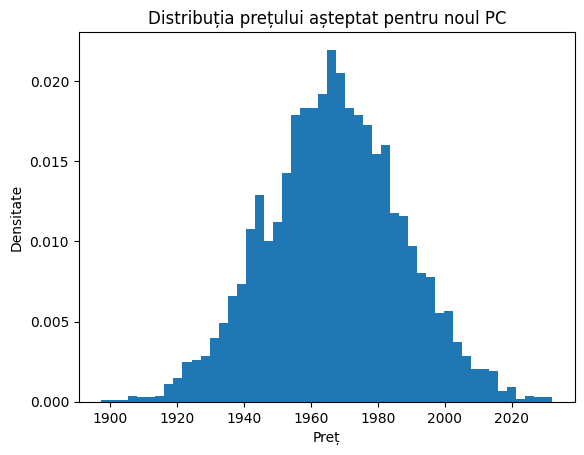

In [6]:
# valori pt noul PC
new_speed = 33
new_harddrive = 540
new_log_harddrive = np.log(new_harddrive)

# simulare pret asteptat (mu)
with model:
    mu_pred = trace.posterior['alpha'] + trace.posterior['beta1'] * new_speed + trace.posterior['beta2'] * new_log_harddrive
    mu_samples = mu_pred.values.flatten()

# interval de credibilitate = 90% HDI
mu_hdi = az.hdi(mu_samples, hdi_prob=0.90)
print(f"90% HDI pentru prețul așteptat: {mu_hdi}")

plt.hist(mu_samples, bins=50, density=True)
plt.title("Distribuția prețului așteptat pentru noul PC")
plt.xlabel("Preț")
plt.ylabel("Densitate")
plt.show()

5. În schimb, să presupunem că acest consumator doreşte să prezică preţul de vânzare al unui computer cu această frecvenţă şi mărime a hard disk-ului. Simulaţi 5000 de extrageri din distribuţia predictivă posterioară şi utilizaţi aceste extrageri simulate pentru a găsi un interval de predicţie de 90% HDI.

In [11]:
import pymc as pm
import arviz as az

print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")


PyMC version: 5.18.2
ArviZ version: 0.20.0


In [ ]:
# simulare pret vanzare (y_pred)
with model:
    y_pred = pm.sample_posterior_predictive(trace, var_names=['y_obs'], samples=5000)['y_obs']

# interval de 90% HDI pt pretul de vanzare
y_hdi = az.hdi(y_pred, hdi_prob=0.90)
print(f"90% interval de predicție pentru prețul de vânzare: {y_hdi}")

# vizualizare distrb pret de vanzare
plt.hist(y_pred, bins=50, density=True)
plt.title("Distribuția prețului de vânzare pentru noul PC")
plt.xlabel("Preț")
plt.ylabel("Densitate")
plt.show()

6. Afectează în vreun fel preţul faptul că producătorul este premium? Justificaţi.

In [23]:
import pymc as pm
import arviz as az
import numpy as np

x1 = data['Speed'].values
x2 = data['log_HardDrive'].values

# convertire variabila 'Premium' din 'yes'/'no' in 1/0
premium = data['Premium'].map({'yes': 1, 'no': 0}).values

y = data['Price'].values

# model cu variabila Premium
with pm.Model() as premium_model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    beta3 = pm.Normal('beta3', mu=0, sigma=10)  # coeficient pt Premium
    sigma = pm.HalfNormal('sigma', sigma=10)

    #pm.Data pt a adauga datele in model
    x1_data = pm.Data('x1', x1)
    x2_data = pm.Data('x2', x2)
    premium_data = pm.Data('premium', premium)

    # creare model cu regresie liniară si variabila premium
    mu = alpha + beta1 * x1_data + beta2 * x2_data + beta3 * premium_data

    # obs (pretul)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # sampling din distrb a posteriori
    trace_premium = pm.sample(2000, tune=1000, target_accept=0.9)

# rezumat coeficient pt Premium
print(az.summary(trace_premium))

# interval HDI pentru beta3 (coef Premium)
beta3_hdi = az.hdi(trace_premium.posterior['beta3'], hdi_prob=0.95)
print(f"95% HDI pentru beta3 (Premium): {beta3_hdi}")

# verif semnificatie impact producator premium pt pret
if 0 not in beta3_hdi:
    print("Producătorul premium afectează semnificativ prețul.")
else:
    print("Producătorul premium NU afectează semnificativ prețul.")


Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━  97% 0:00:01 / 0:00:18

          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha   38.234  9.838   19.692   56.839      0.159    0.114    3824.0   
beta1   15.489  0.686   14.172   16.753      0.013    0.010    2589.0   
beta2  222.757  6.433  211.080  235.572      0.130    0.092    2440.0   
beta3   19.828  9.999    0.155   37.890      0.161    0.120    3864.0   
sigma  317.142  4.841  308.189  326.373      0.082    0.058    3403.0   

       ess_tail  r_hat  
alpha    2867.0    1.0  
beta1    2530.0    1.0  
beta2    2357.0    1.0  
beta3    2608.0    1.0  
sigma    2410.0    1.0  
95% HDI pentru beta3 (Premium): <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta3    (hdi) float64 16B -0.4199 39.06
Producătorul premium afectează semnificativ prețul.
